In [1]:
#!pip install --upgrade typing-extensions

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl

# Constants
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

# Custom CIFAR10DataModule with Albumentations transformations
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_path):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path

    def prepare_data(self):
        # Download the dataset here (not necessary for CIFAR10, as it's available through torchvision)
        pass

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=means, std=stds)
            ])

            self.train_dataset = datasets.CIFAR10(root=self.data_path, train=True, download=True, transform=transform_train)

        if stage == 'test' or stage is None:
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=means, std=stds)
            ])

            self.test_dataset = datasets.CIFAR10(root=self.data_path, train=False, download=True, transform=transform_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)

#datamodule = CIFAR10DataModule(batch_size=256, data_path='./data')

C:\Users\INHOPE\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\INHOPE\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
C:\Users\INHOPE\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\INHOPE\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

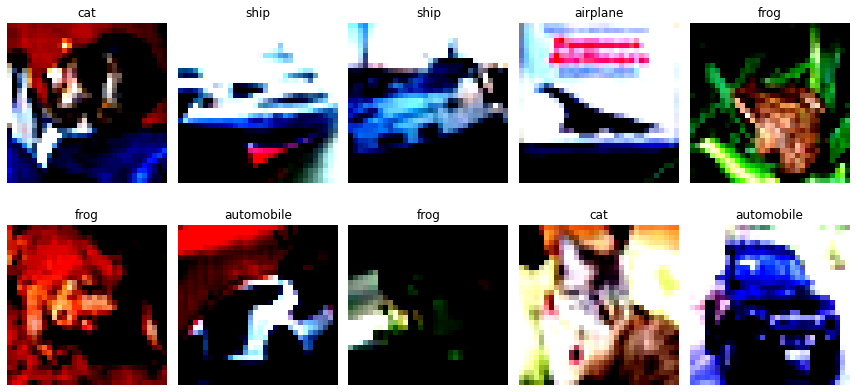

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import numpy as np

# Function to get class names from CIFAR10
def get_class_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize the data module
datamodule = CIFAR10DataModule(batch_size=10, data_path='./data')

# Load the test data using the data module
datamodule.prepare_data()
datamodule.setup('test')
test_loader = datamodule.test_dataloader()

# Get class names
class_names = get_class_names()

# Get a batch of images and labels from the test data loader
images, labels = next(iter(test_loader))

# Convert the images and labels to numpy arrays
images = images.numpy()
labels = labels.numpy()

# Plot the images and their corresponding categories
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR
train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
from resnet import ResNet18
model = ResNet18()
class ModelS10(pl.LightningModule):
    def __init__(self):
        super(ModelS10, self).__init__()
        self.model = ResNet18()

    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).item() / float(len(y))
        #precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        #self.log('train_precision', precision, prog_bar=True)
        train_loss.append(loss)
        train_accuracy.append(accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        accuracy = torch.sum(preds == y).item() / float(len(y))
        #precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_accuracy', accuracy, prog_bar=True)
        #self.log('test_precision', precision, prog_bar=True)
        test_loss.append(loss)
        test_accuracy.append(accuracy)
        return loss
    
    def configure_optimizers(self):
        assert self.datamodule is not None
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003, weight_decay=1e-4)

        # Define the One Cycle LR scheduler
        scheduler = OneCycleLR(
            optimizer,
            max_lr=4.15E-02,  # The maximum learning rate to be used
            total_steps=len(self.datamodule.train_dataloader()) * self.trainer.max_epochs,  # Total number of training steps
            anneal_strategy='linear',  # Annealing strategy for learning rate schedule
            cycle_momentum=False,  # If True, also applies one cycle policy to momentum
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',  # Set the scheduler to be called after every training step
                'frequency': 1,  # How often to call the scheduler (every training step in this case)
            }
        }


In [7]:
#def main():
    # Initialize the model and move it to GPU
datamodule = CIFAR10DataModule(batch_size=256, data_path='./data')
model = ModelS10().to('cuda')
model.datamodule = datamodule

# Initialize the data module
    

 # Initialize the Trainer and specify the GPU to use (e.g., first GPU with accelerator='ddp' or 'dp')
trainer = pl.Trainer(max_epochs=25, accelerator='auto')  # Set accelerator='ddp' for DataParallel

    # Train the model
trainer.fit(model, datamodule=datamodule)

    # Test the model
trainer.test(datamodule=datamodule)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.
C:\Users\INHOPE\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified


Restoring states from the checkpoint path at C:\Users\INHOPE\Pytorc_ERA\s12\lightning_logs\version_42\checkpoints\epoch=24-step=4900.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\INHOPE\Pytorc_ERA\s12\lightning_logs\version_42\checkpoints\epoch=24-step=4900.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.848800003528595
        test_loss           0.4525425434112549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4525425434112549, 'test_accuracy': 0.848800003528595}]

Text(0.5, 1.0, 'Loss per epoch')

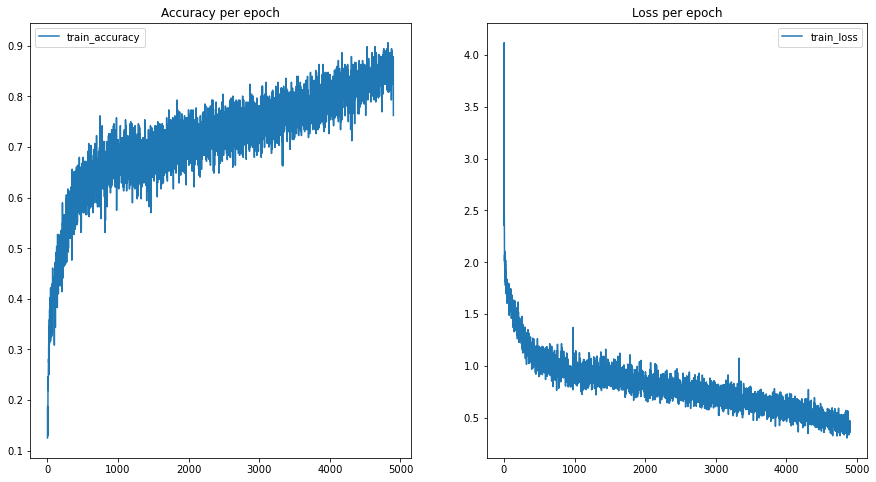

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy))
#plt.plot(np.array(test_accuracy), 'r')
plt.legend(["train_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss)
#plt.plot(test_loss, 'r')
plt.legend(["train_loss"])
plt.title("Loss per epoch")

Text(0.5, 1.0, 'Loss per epoch')

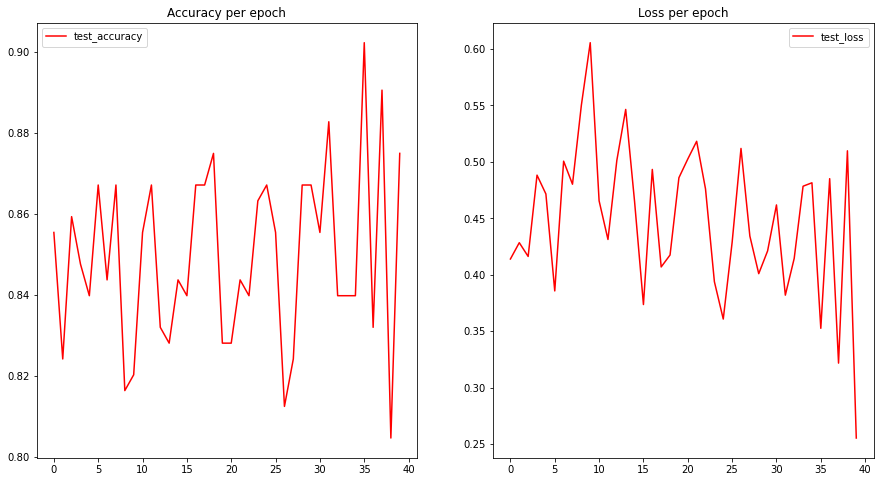

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

#plt.plot(np.array(train_accuracy))
plt.plot(np.array(test_accuracy), 'r')
plt.legend([ "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
#plt.plot(train_loss)
plt.plot(test_loss, 'r')
plt.legend(["test_loss"])
plt.title("Loss per epoch")

In [10]:
result = trainer.test(datamodule=datamodule)

C:\Users\INHOPE\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified


Restoring states from the checkpoint path at C:\Users\INHOPE\Pytorc_ERA\s12\lightning_logs\version_42\checkpoints\epoch=24-step=4900.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\INHOPE\Pytorc_ERA\s12\lightning_logs\version_42\checkpoints\epoch=24-step=4900.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.848800003528595
        test_loss           0.4525425434112549
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
def find_misclassified_images(model, test_loader, max_images=None):
    model.eval()
    misclassified_idx = []
    misclassified_preds = []
    device = next(model.parameters()).device  # Get the device of the model's parameters
    num_images_processed = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        misclassified_mask = predicted != targets
        misclassified_indices = misclassified_mask.nonzero().squeeze().cpu().tolist()
        misclassified_idx.extend(misclassified_indices)

        # Save the predicted labels for the misclassified images
        misclassified_preds.extend([test_loader.dataset.classes[p.item()] for p in predicted[misclassified_mask]])

        num_images_processed += len(targets)

        if max_images is not None and num_images_processed >= max_images:
            break

    return misclassified_idx, misclassified_preds

In [12]:
misclassified_idx,misclassified_preds = find_misclassified_images(model, datamodule.test_dataloader(), max_images=200)

In [13]:
def visualize_misclassified_images(test_dataset, misclassified_idx, misclassified_preds, num_images=10):
    misclassified_images = torch.stack([test_dataset[i][0] for i in misclassified_idx[:num_images]])
    misclassified_labels = [test_dataset.classes[test_dataset[i][1]] for i in misclassified_idx[:num_images]]
    misclassified_predicted = misclassified_preds[:num_images]

    num_rows = 2
    num_cols = num_images // num_rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx >= num_images:
                break
            image = misclassified_images[idx].permute(1, 2, 0)
            label = misclassified_labels[idx]
            predicted = misclassified_predicted[idx]
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"Actual: {label}; Misclassified: {predicted}")
            axs[i, j].axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

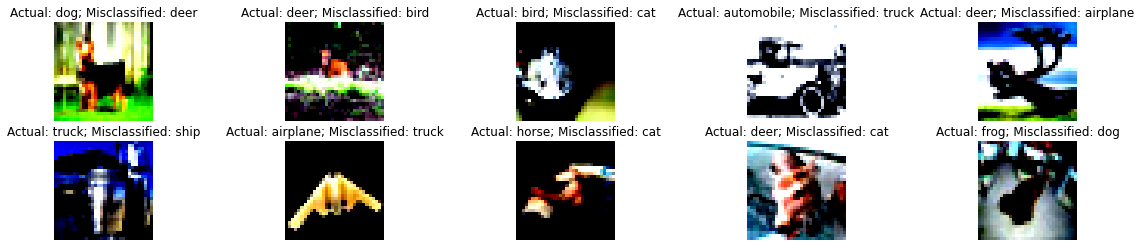

In [14]:
visualize_misclassified_images(datamodule.test_dataset, misclassified_idx,misclassified_preds,  num_images=10)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups: 
        return param_group['lr']
model = ModelS10().to('cuda')

In [24]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = random_split(dataset, [45000, 5000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

Files already downloaded and verified


  0%|          | 0/400 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.15E-02


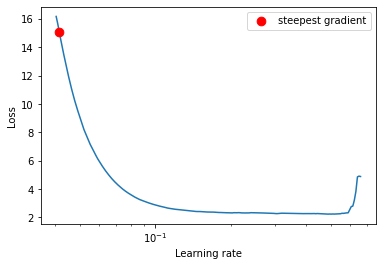

In [27]:
from  torch_lr_finder import LRFinder 

optimizer = torch.optim.Adam(model.parameters(), lr=0.035, weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model,optimizer,  criterion, device= "cuda" )
lr_finder.range_test ( train_loader, end_lr = 10, num_iter =400, step_mode ="exp")
lr_finder.plot()
lr_finder.reset()